In [44]:
# Setup sys.path to import from src/
import sys
import os
import pandas as pd

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

import numpy as np
import json

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [45]:
# Spark session
from pyspark.sql import SparkSession, functions as F

# Import custom functions
from src.preprocessing import load_data, clean_data, feature_engineer, assemble_features
from src.save_outputs import save_predictions, save_feature_importances, save_model_metadata
from src.model import pick_best_model_from_grid,pick_best_category_model_from_grid, evaluate_model, manual_grid_search_rf, manual_grid_search_dt, manual_grid_search_gbt, manual_grid_search_lr, manual_grid_search_nb, manual_grid_search_category
from src.mongo_export import create_mongo_database, get_collection

In [46]:
spark = SparkSession.builder \
    .appName("Ecommerce Behavior Exploration") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()


In [47]:
# Load raw dataset
file_path = "../data/scaleData-2019-Nov.csv"
raw_df = load_data(file_path, spark)

# Quick look at raw data
raw_df.show(5)
raw_df.printSchema()

+--------------------+----------+----------+-------------------+--------------------+--------+------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand| price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+--------+------+---------+--------------------+
|2019-11-19 08:35:...|      view|  30200005|2053013554449088861|                NULL|   elari|  77.2|512412397|f62be3c5-18af-4ab...|
|2019-11-26 14:16:...|      view|   1005115|2053013555631882655|electronics.smart...|   apple|916.37|568675496|c857db53-cd0a-480...|
|2019-11-10 17:50:...|      view|  15700275|2053013559733912211|                NULL|imperial|206.16|513262731|c637d18a-6fc5-4c1...|
|2019-11-04 14:23:...|      view|   1004589|2053013555631882655|electronics.smart...|    inoi| 61.36|562973725|e41d3c3f-830e-48d...|
|2019-11-29 17:11:...|  purchase|   5300157|2053013563173241677|     

In [48]:
# Clean the dataset
clean_df = clean_data(raw_df)

# Quick check after cleaning
clean_df.show(5)

+-------------------+----------+----------+-------------------+--------------------+--------+------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand| price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+------+---------+--------------------+
|2019-11-19 03:35:46|      view|  30200005|2053013554449088861|                NULL|   elari|  77.2|512412397|f62be3c5-18af-4ab...|
|2019-11-26 09:16:08|      view|   1005115|2053013555631882655|electronics.smart...|   apple|916.37|568675496|c857db53-cd0a-480...|
|2019-11-10 12:50:50|      view|  15700275|2053013559733912211|                NULL|imperial|206.16|513262731|c637d18a-6fc5-4c1...|
|2019-11-04 09:23:52|      view|   1004589|2053013555631882655|electronics.smart...|    inoi| 61.36|562973725|e41d3c3f-830e-48d...|
|2019-11-29 12:11:17|  purchase|   5300157|2053013563173241677|             

# Model 1 (Purchase Probability)

In [49]:
# Create new features if needed
feature_df = feature_engineer(clean_df)

# Quick preview
feature_df.show(5)

+--------------------+---------+-------------+-------------+-------------------+-------------------+---------+----------------+-------------+-----------------+
|        user_session|num_views|num_cart_adds|num_purchases|      session_start|        session_end|avg_price|session_duration|main_category|unique_categories|
+--------------------+---------+-------------+-------------+-------------------+-------------------+---------+----------------+-------------+-----------------+
|3c860f3f-eb6e-42f...|        2|            0|            0|2019-11-22 09:13:55|2019-11-22 09:14:13|  477.995|              18|  electronics|                1|
|4b83fb13-2e1a-42e...|        1|            0|            0|2019-11-05 09:38:37|2019-11-05 09:38:37|   154.42|               0|    furniture|                1|
|70f7c721-cd82-4e2...|        1|            0|            0|2019-11-15 13:23:59|2019-11-15 13:23:59|    76.96|               0|  electronics|                1|
|71697745-4b20-419...|        1|        

In [50]:
labels = clean_df.groupBy("user_session").agg(
    (F.max(F.when(F.col("event_type") == "purchase", 1).otherwise(0))).alias("label")
)

temp_df = feature_df.join(labels, on="user_session", how="left").fillna(0)

In [51]:
# StringIndexer for category
indexer_1 = StringIndexer(inputCol="main_category", outputCol="main_category_index")
df_indexed = indexer_1.fit(temp_df).transform(temp_df)

# One-hot encode
encoder = OneHotEncoder(inputCols=["main_category_index"], outputCols=["main_category_ohe"])
final_df = encoder.fit(df_indexed).transform(df_indexed)

In [52]:
index_map = indexer_1.fit(temp_df).labels
pd.DataFrame({'index': list(range(len(index_map))), 'category': index_map}) \
    .to_csv('../output/model1_index_mapping.csv', index=False)

In [53]:
final_df.show(5)

+--------------------+---------+-------------+-------------+-------------------+-------------------+---------+----------------+-------------+-----------------+-----+-------------------+-----------------+
|        user_session|num_views|num_cart_adds|num_purchases|      session_start|        session_end|avg_price|session_duration|main_category|unique_categories|label|main_category_index|main_category_ohe|
+--------------------+---------+-------------+-------------+-------------------+-------------------+---------+----------------+-------------+-----------------+-----+-------------------+-----------------+
|00010158-3abd-406...|        1|            0|            0|2019-11-30 02:30:03|2019-11-30 02:30:03|   229.59|               0|  electronics|                1|    0|                0.0|   (12,[0],[1.0])|
|000656d3-d4b3-42f...|        1|            0|            0|2019-11-15 00:01:30|2019-11-15 00:01:30|   127.31|               0|  electronics|                1|    0|                0.0

In [54]:
# 1. Assemble numeric features
numeric_cols = ['num_views', 'num_cart_adds', 'session_duration', 'avg_price', 'unique_categories']
assembler_numeric = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")
final_df = assembler_numeric.transform(final_df)

# 2. Combine numeric + one-hot category vector
assembler_all = VectorAssembler(inputCols=["numeric_features", "main_category_ohe"], outputCol="features")
final_df = assembler_all.transform(final_df)

In [55]:
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

In [56]:
manual_grid_search_rf(train_df, test_df)

🚀 Starting Manual Random Forest grid search...
🔵 Training: param1=50, param2=5, param3=32


2025/05/11 17:59:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
d:\ecomm-bigdata-project\src\model.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, new_row], ignore_index=True)


✔ Logged run with AUC=0.9958
✅ Predictions saved with class 1 probabilities: ../output/rf/rf_50_5_32\predictions.csv
✅ Feature importances saved: ../output/rf/rf_50_5_32\feature_importances.csv
✅ Model metadata saved: ../output/rf/rf_50_5_32\metadata.json
🏃 View run valuable-sow-161 at: http://localhost:5000/#/experiments/1/runs/451abece2e5a4e14bec325ec9281f759
🧪 View experiment at: http://localhost:5000/#/experiments/1
🔵 Training: param1=100, param2=5, param3=32


2025/05/11 18:04:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔ Logged run with AUC=0.9969
✅ Predictions saved with class 1 probabilities: ../output/rf/rf_100_5_32\predictions.csv
✅ Feature importances saved: ../output/rf/rf_100_5_32\feature_importances.csv
✅ Model metadata saved: ../output/rf/rf_100_5_32\metadata.json
🏃 View run amazing-ram-854 at: http://localhost:5000/#/experiments/1/runs/7c3e9e9343ff4752977252d269ea8f4b
🧪 View experiment at: http://localhost:5000/#/experiments/1
🔵 Training: param1=50, param2=10, param3=32


2025/05/11 18:09:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔ Logged run with AUC=0.9973
✅ Predictions saved with class 1 probabilities: ../output/rf/rf_50_10_32\predictions.csv
✅ Feature importances saved: ../output/rf/rf_50_10_32\feature_importances.csv
✅ Model metadata saved: ../output/rf/rf_50_10_32\metadata.json
🏃 View run efficient-rat-490 at: http://localhost:5000/#/experiments/1/runs/b7af33927bc74809a844b419589edefd
🧪 View experiment at: http://localhost:5000/#/experiments/1
🔵 Training: param1=100, param2=10, param3=32


2025/05/11 18:14:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔ Logged run with AUC=0.9975
✅ Predictions saved with class 1 probabilities: ../output/rf/rf_100_10_32\predictions.csv
✅ Feature importances saved: ../output/rf/rf_100_10_32\feature_importances.csv
✅ Model metadata saved: ../output/rf/rf_100_10_32\metadata.json
🏃 View run bemused-colt-832 at: http://localhost:5000/#/experiments/1/runs/3e81c7a1b64e4e6ca62614a1e70b63a3
🧪 View experiment at: http://localhost:5000/#/experiments/1
🔵 Training: param1=100, param2=5, param3=64


2025/05/11 18:19:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔ Logged run with AUC=0.9963
✅ Predictions saved with class 1 probabilities: ../output/rf/rf_100_5_64\predictions.csv
✅ Feature importances saved: ../output/rf/rf_100_5_64\feature_importances.csv
✅ Model metadata saved: ../output/rf/rf_100_5_64\metadata.json
🏃 View run resilient-midge-807 at: http://localhost:5000/#/experiments/1/runs/4201744f6c634bc1bbd13aeb4627d440
🧪 View experiment at: http://localhost:5000/#/experiments/1
🔵 Training: param1=200, param2=20, param3=64


2025/05/11 18:26:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔ Logged run with AUC=0.9972
✅ Predictions saved with class 1 probabilities: ../output/rf/rf_200_20_64\predictions.csv
✅ Feature importances saved: ../output/rf/rf_200_20_64\feature_importances.csv
✅ Model metadata saved: ../output/rf/rf_200_20_64\metadata.json
🏃 View run whimsical-hawk-167 at: http://localhost:5000/#/experiments/1/runs/dc6a838ea32a4ca098c3edde0664a977
🧪 View experiment at: http://localhost:5000/#/experiments/1
✅ Random Forest grid search completed.


In [57]:
manual_grid_search_lr(train_df, test_df)

🚀 Starting Manual Logistic Regression grid search...
⏩ Skipping: param1=50, param2=0.0, param3=0.0
⏩ Skipping: param1=100, param2=0.1, param3=0.0
⏩ Skipping: param1=100, param2=0.01, param3=0.5
⏩ Skipping: param1=200, param2=0.01, param3=1.0
✅ Logistic Regression grid search completed.


In [58]:
manual_grid_search_dt(train_df, test_df)

🚀 Starting Manual Decision Tree grid search...
⏩ Skipping: param1=5, param2=32
⏩ Skipping: param1=10, param2=32
⏩ Skipping: param1=20, param2=32
⏩ Skipping: param1=5, param2=64
⏩ Skipping: param1=10, param2=64
✅ Decision Tree grid search completed.


In [59]:
manual_grid_search_gbt(train_df, test_df),

🚀 Starting Manual GBTClassifier grid search...
⏩ Skipping already trained: param1=50, param2=5, param3=32
⏩ Skipping already trained: param1=100, param2=5, param3=32
⏩ Skipping already trained: param1=50, param2=10, param3=64
⏩ Skipping already trained: param1=100, param2=10, param3=64

✅ Manual Grid Search Complete for GBTClassifier!


(None,)

In [60]:
# for random forest model

base_rf_dir = "../output/rf/"
base_lr_dir = "../output/lr/"
base_dt_dir = "../output/dt/"
base_gbt_dir = "../output/gbt/"

dic = {"model":"", "params": "", "AUC": 0 }

results = []

print("RF: ")
results_csv_path_rf = os.path.join(base_rf_dir, "grid_search_results.csv")
results.append(pick_best_model_from_grid(results_csv_path_rf, base_rf_dir).split(','))

print("LR: ")
results_csv_path_lr = os.path.join(base_lr_dir, "grid_search_results.csv")
results.append(pick_best_model_from_grid(results_csv_path_lr, base_lr_dir).split(','))

print("DT: ")
results_csv_path_dt = os.path.join(base_dt_dir, "grid_search_results.csv")
results.append(pick_best_model_from_grid(results_csv_path_dt, base_dt_dir).split(','))

print("GBT: ")
results_csv_path_gbt = os.path.join(base_gbt_dir, "grid_search_results.csv")
results.append(pick_best_model_from_grid(results_csv_path_gbt, base_gbt_dir).split(','))

for r in results:
    if float(r[1]) >= dic["AUC"]:
        dic["model"] = r[2]
        dic["params"] = r[0]
        dic["AUC"] = float(r[1])
print(dic)

RF: 
🏆 Best Model: 100_10_32 with AUC: 0.9975
LR: 
🏆 Best Model: 100_0_0 with AUC: 0.9677
DT: 
🏆 Best Model: 5_32 with AUC: 0.9914
GBT: 
🏆 Best Model: 100_5_32 with AUC: 0.9965
{'model': 'rf', 'params': '100_10_32', 'AUC': 0.997512544731366}


In [61]:
# Save a list of best hyperparameters or feature names
with open("../output/best_params.json", "w") as f:
    json.dump(dic, f)


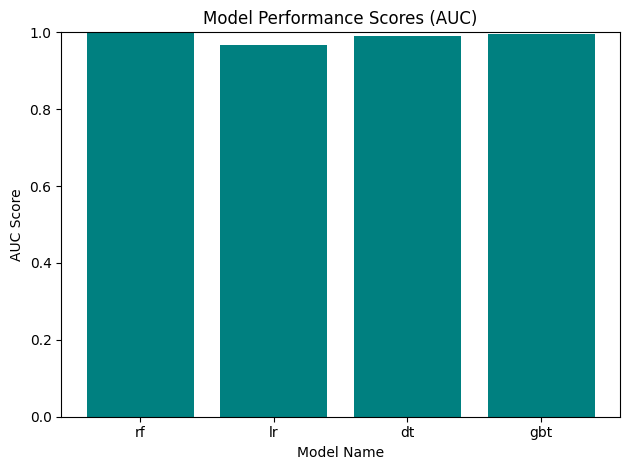

In [62]:
model_performance_dic = {}
for r in results:
    model_performance_dic[r[2]] = float(r[1])
plt.bar(model_performance_dic.keys(), model_performance_dic.values(), color='teal')
plt.ylabel("AUC Score")
plt.xlabel("Model Name")
plt.ylim(0, 1)
plt.title("Model Performance Scores (AUC)")
plt.tight_layout()
plt.savefig("../output/figures/model_performance_scores.png")
plt.show()

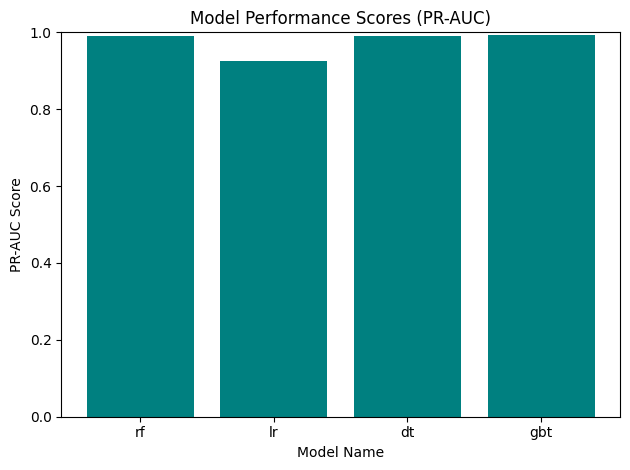

In [63]:
model_performance_dic = {}
for r in results:
    model_performance_dic[r[2]] = float(r[3])
plt.bar(model_performance_dic.keys(), model_performance_dic.values(), color='teal')
plt.ylabel("PR-AUC Score")
plt.xlabel("Model Name")
plt.ylim(0, 1)
plt.title("Model Performance Scores (PR-AUC)")
plt.tight_layout()
plt.savefig("../output/figures/model_performance_scores_pr_auc.png")
plt.show()

# MODEL 2 (Category Prediction)

In [64]:
model2df = feature_engineer(clean_df, True)

# Define the feature columns (exclude label and non-numeric ones)
feature_cols = ['num_views', 'num_cart_adds', 'num_purchases', 'avg_price', 'session_duration', 'unique_categories']

indexer = StringIndexer(inputCol="label_category", outputCol="label")
indexer_model = indexer.fit(model2df)
model2df = indexer_model.transform(model2df)

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

model2df = assembler.transform(model2df)

In [65]:
category_mapping = indexer_model.labels  # from StringIndexer
pd.DataFrame({'index': list(range(len(category_mapping))), 'category': category_mapping}) \
    .to_csv('../output/category/category_index_mapping.csv', index=False)


In [66]:
model2df.show(5)

+--------------------+---------+-------------+-------------+-------------------+-------------------+---------+----------------+-------------+-----------------+--------------+-----+--------------------+
|        user_session|num_views|num_cart_adds|num_purchases|      session_start|        session_end|avg_price|session_duration|main_category|unique_categories|label_category|label|            features|
+--------------------+---------+-------------+-------------+-------------------+-------------------+---------+----------------+-------------+-----------------+--------------+-----+--------------------+
|00577e83-1d56-478...|        0|            0|            1|2019-11-24 07:03:18|2019-11-24 07:03:18|   460.22|               0|  electronics|                1|   electronics|  0.0|[0.0,0.0,1.0,460....|
|00752842-be99-4fc...|        0|            0|            1|2019-11-28 04:23:01|2019-11-28 04:23:01|   231.64|               0|   appliances|                1|    appliances|  1.0|[0.0,0.0,1.0

In [67]:
train_df, test_df = model2df.randomSplit([0.8, 0.2], seed=42)

In [68]:
manual_grid_search_category(train_df, test_df)

🚀 Starting Manual Grid Search for Category Prediction...
⏩ Skipping ('rf', '50_5')
⏩ Skipping ('rf', '100_10')
⏩ Skipping ('lr', '50')
⏩ Skipping ('lr', '100')
⏩ Skipping ('dt', '5')
⏩ Skipping ('dt', '10')
✅ Category Model Grid Search Completed.


In [69]:
# for random forest model

base_dir = "../output/category/"

category_dic = {"model":"", "params": "", "accuracy": 0 }

results_csv_path = os.path.join(base_dir, "grid_search_results.csv")
result = pick_best_category_model_from_grid(results_csv_path).split(',')

category_dic["model"] = result[2]
category_dic["params"] = result[0]
category_dic["accuracy"] = float(result[1])
print(category_dic)

🏆 Best Model: 5 with accuracy: 0.7397
{'model': 'dt', 'params': '5', 'accuracy': 0.7397464578672632}


In [70]:
# Save a list of best hyperparameters or feature names
with open("../output/best_category_params.json", "w") as f:
    json.dump(category_dic, f)

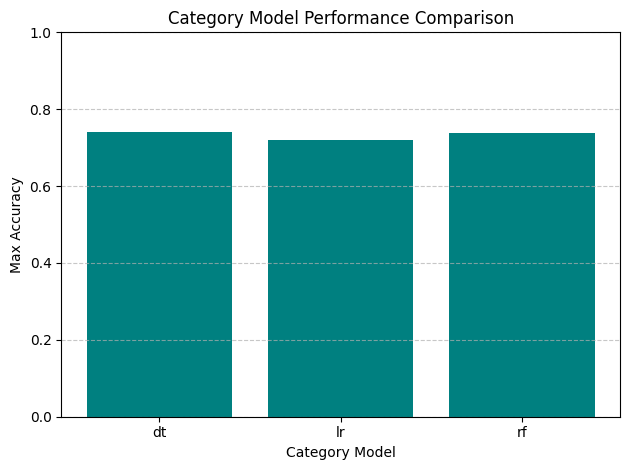

In [71]:
df_cat = pd.read_csv(results_csv_path)
max_accuracies = df_cat.groupby("model")["accuracy"].max().reset_index()

# Plot
plt.bar(max_accuracies["model"], max_accuracies["accuracy"], color = 'teal')
plt.ylabel("Max Accuracy")
plt.xlabel("Category Model")
plt.ylim(0, 1)
plt.title("Category Model Performance Comparison")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("../output/figures/category_model_performance.png")
plt.show()


# Storing Model 1 Predictions in MongoDB

In [72]:
# Load predictions CSV (adjust path if needed)
modelname, params = dic["model"], dic["params"]
predictions_path = f"../output/{modelname}/{modelname}_{params}/predictions.csv"
df_predictions = pd.read_csv(predictions_path)

In [73]:
df_predictions.head()

,user_session,num_views,num_cart_adds,label,prediction,session_duration,avg_price,main_category_ohe,unique_categories
0,0009b84b-c874-85be-815c-725adc425fdd,1,0,0,0.0,0,257.38,"(12,[0],[1.0])",1
1,000f10ac-6fda-c730-88f3-49d8ce7840b2,1,0,0,0.0,0,566.27,"(12,[0],[1.0])",1
2,00120f5e-3232-4e5b-a035-0bbab87e900e,1,0,0,0.0,0,124.30,"(12,[0],[1.0])",1
3,00150def-8313-4c82-9ab8-c227c0d45d0b,1,0,0,0.0,0,952.07,"(12,[0],[1.0])",1
4,0019dc56-eda8-4087-a8c9-d8922b275f8c,1,0,0,0.0,0,344.64,"(12,[1],[1.0])",1


In [74]:
labels = indexer_1.fit(temp_df).labels  # List of category strings

# Convert string like '[0.0, 0.0, 1.0, 0.0]' to a list of floats

def parse_ohe_vector(ohe):
    try:
        # Match the index inside [ ] using regex
        match = re.search(r'\[\s*(\d+)\s*\]', ohe)
        if match:
            return int(match.group(1))
        else:
            return -1
    except:
        return -1


df_predictions["main_category_index"] = df_predictions["main_category_ohe"].apply(parse_ohe_vector)

# Convert float index to integer for lookup
df_predictions["main_category"] = df_predictions["main_category_index"].map(
    lambda i: labels[i] if 0 <= i < len(labels) else "unknown"
)

In [75]:
df_predictions.head()

,user_session,num_views,num_cart_adds,label,prediction,session_duration,avg_price,main_category_ohe,unique_categories,main_category_index,main_category
0,0009b84b-c874-85be-815c-725adc425fdd,1,0,0,0.0,0,257.38,"(12,[0],[1.0])",1,0,electronics
1,000f10ac-6fda-c730-88f3-49d8ce7840b2,1,0,0,0.0,0,566.27,"(12,[0],[1.0])",1,0,electronics
2,00120f5e-3232-4e5b-a035-0bbab87e900e,1,0,0,0.0,0,124.30,"(12,[0],[1.0])",1,0,electronics
3,00150def-8313-4c82-9ab8-c227c0d45d0b,1,0,0,0.0,0,952.07,"(12,[0],[1.0])",1,0,electronics
4,0019dc56-eda8-4087-a8c9-d8922b275f8c,1,0,0,0.0,0,344.64,"(12,[1],[1.0])",1,1,appliances


In [76]:
create_mongo_database(df_predictions.to_dict(orient='records'))

# Visualizations

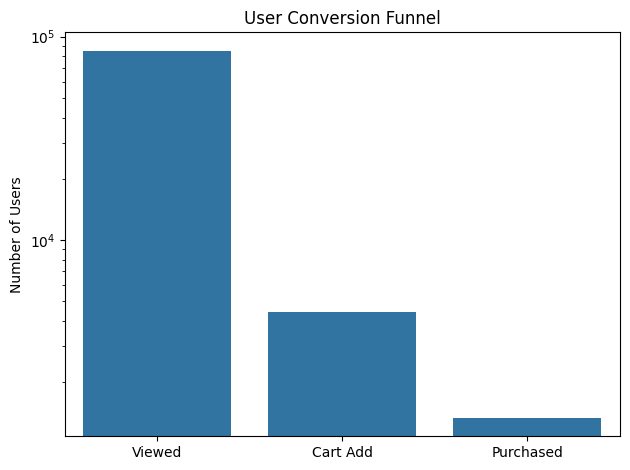

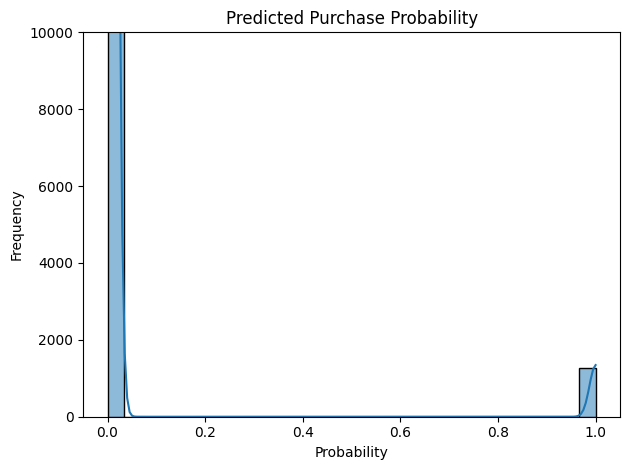

In [77]:
output_dir = "../output/figures"
os.makedirs(output_dir, exist_ok=True)

collection = get_collection()
# Fetch from MongoDB
df_mongo = pd.DataFrame(list(collection.find()))

# Drop MongoDB's default _id field
df_mongo = df_mongo.drop(columns=["_id"], errors='ignore')

# --- Visualization 1: Conversion Funnel ---
funnel = {
    "Viewed": df_mongo.shape[0],
    "Cart Add": df_mongo[df_mongo["num_cart_adds"] > 0].shape[0],
    "Purchased": df_mongo[df_mongo["label"] == 1].shape[0]
}
sns.barplot(x=list(funnel.keys()), y=list(funnel.values()))
plt.title("User Conversion Funnel")
plt.ylabel("Number of Users")
plt.yscale('log')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "conversion_funnel.png"), dpi=300)
plt.show()

# --- Visualization 2: Predicted Purchase Probabilities ---
if 'prediction' in df_mongo.columns:
    sns.histplot(df_mongo['prediction'], bins=30, kde=True)
    plt.title("Predicted Purchase Probability")
    plt.xlabel("Probability")
    plt.ylabel("Frequency")
    plt.ylim(0, 10000)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "purchase_probability.png"), dpi=300)
    plt.show()

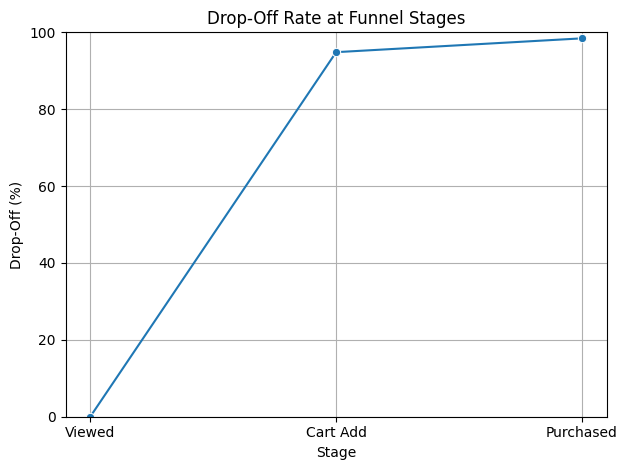

In [78]:
funnel_df = pd.DataFrame({
    "Stage": ["Viewed", "Cart Add", "Purchased"],
    "Users": [funnel["Viewed"], funnel["Cart Add"], funnel["Purchased"]]
})
funnel_df["Dropoff %"] = 100 * (1 - funnel_df["Users"] / funnel_df["Users"].iloc[0])

sns.lineplot(data=funnel_df, x="Stage", y="Dropoff %", marker="o")
plt.title("Drop-Off Rate at Funnel Stages")
plt.ylabel("Drop-Off (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.savefig("../output/figures/dropoff_rate.png")
plt.show()

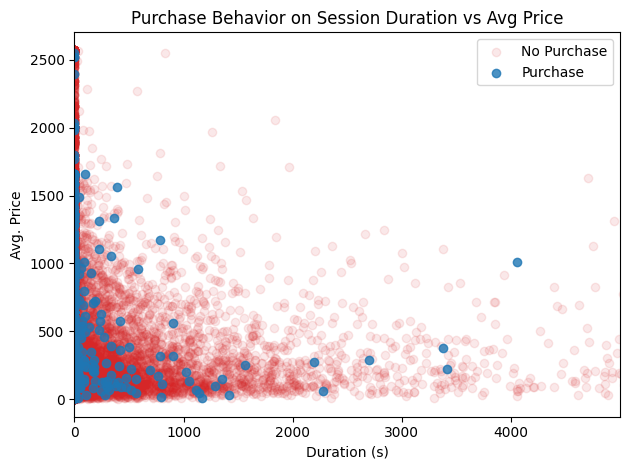

In [79]:
colors = {0: "tab:red", 1:"tab:blue"}
alphas = {0:0.1, 1:0.8}
labels = {0: "No Purchase", 1: "Purchase"}
plt.figure()

for label in [0, 1]:
    subset = df_mongo[df_mongo['label'] == label]
    plt.scatter(
        subset["session_duration"],
        subset["avg_price"],
        c=colors[label],
        alpha=alphas[label],
        label=labels[label]
    )
plt.title("Purchase Behavior on Session Duration vs Avg Price")
plt.xlabel("Duration (s)")
plt.xticks(np.arange(0, 5000, 1000))
plt.xlim(0, 5000)
plt.ylabel("Avg. Price")
plt.legend()
plt.tight_layout()
plt.savefig("../output/figures/purchase_on_duration_vs_avg_price.png")
plt.show()

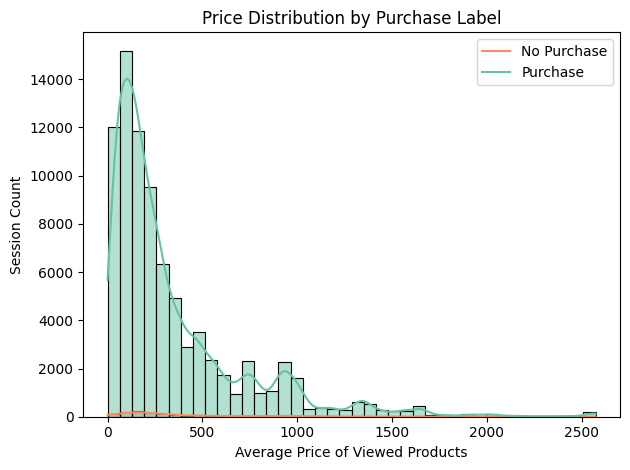

In [80]:
sns.histplot(data=df_mongo, x="avg_price", hue="label", bins=40, kde=True, palette="Set2")
plt.title("Price Distribution by Purchase Label")
plt.xlabel("Average Price of Viewed Products")
plt.ylabel("Session Count")
plt.legend(["No Purchase", "Purchase"])
plt.tight_layout()
plt.savefig("../output/figures/price_vs_purchase.png")
plt.show()

In [81]:
# Stage 1: Viewed (all sessions)
views = df_mongo.groupby("main_category").size().rename("viewed")

# Stage 2: Cart Add
cart_adds = df_mongo[df_mongo["num_cart_adds"] > 0].groupby("main_category").size().rename("cart")

# Stage 3: Purchase
purchases = df_mongo[df_mongo["label"] == 1].groupby("main_category").size().rename("purchased")

# Combine into one DataFrame
category_funnel = pd.concat([views, cart_adds, purchases], axis=1).fillna(0).astype(int)
category_funnel = category_funnel.sort_values("viewed", ascending=False)
category_funnel.reset_index(inplace=True)

category_funnel["cart_rate"] = (category_funnel["cart"] / category_funnel["viewed"]).round(2)
category_funnel["purchase_rate"] = (category_funnel["purchased"] / category_funnel["cart"]).replace({np.inf: 0, np.nan: 0}).round(2)

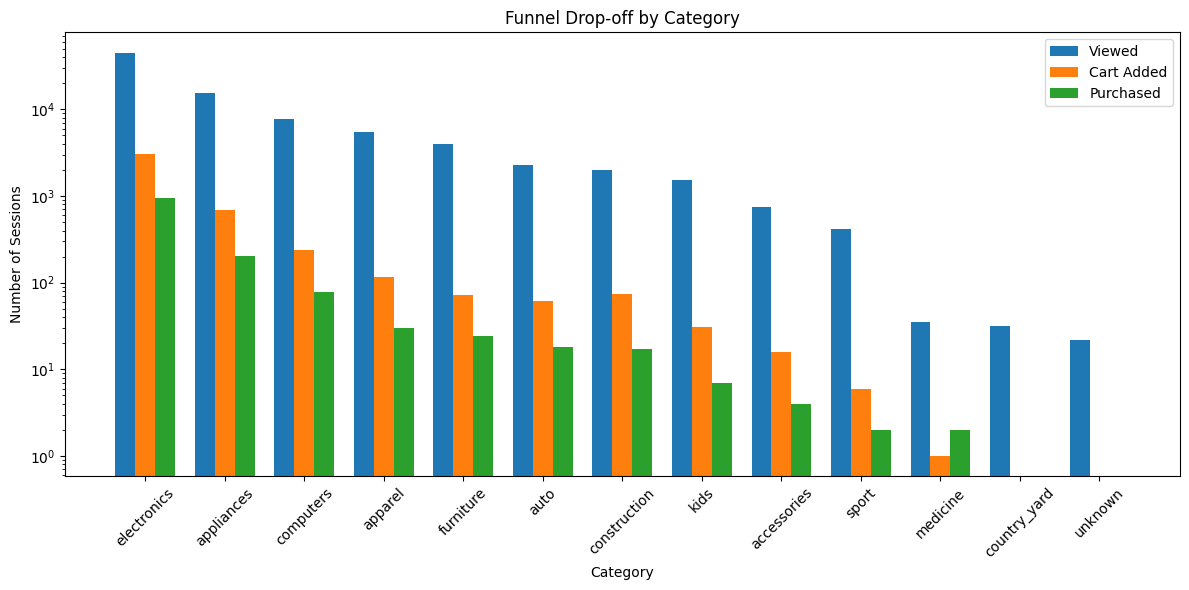

In [82]:
plt.figure(figsize=(12, 6))
x = range(len(category_funnel))

plt.bar(x, category_funnel["viewed"], width=0.25, label="Viewed")
plt.bar([i + 0.25 for i in x], category_funnel["cart"], width=0.25, label="Cart Added")
plt.bar([i + 0.50 for i in x], category_funnel["purchased"], width=0.25, label="Purchased")

plt.xticks([i + 0.25 for i in x], category_funnel["main_category"], rotation=45)
plt.xlabel("Category")
plt.ylabel("Number of Sessions")
plt.title("Funnel Drop-off by Category")
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig("../output/figures/funnel_dro_off_by_category.png")
plt.show()

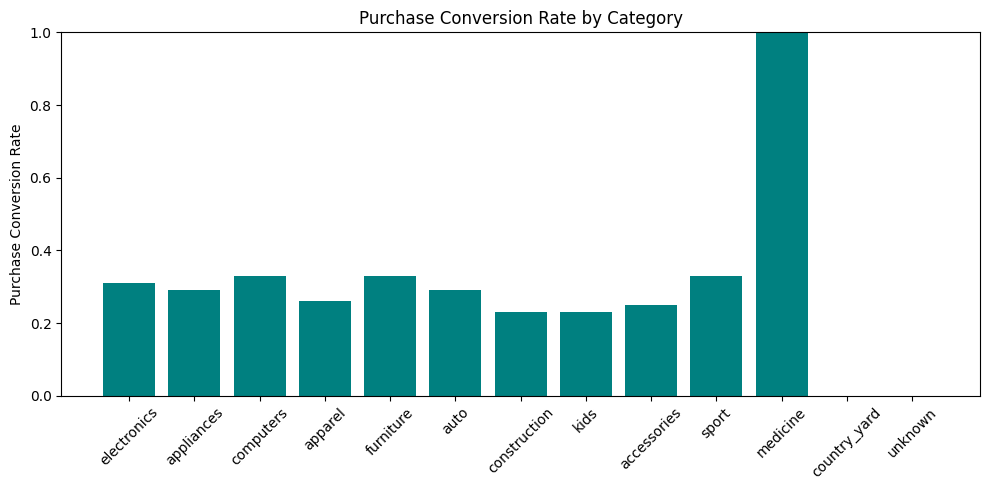

In [83]:
plt.figure(figsize=(10, 5))
plt.bar(category_funnel["main_category"], category_funnel["purchase_rate"], color='teal')
plt.ylabel("Purchase Conversion Rate")
plt.ylim(0,1)
plt.title("Purchase Conversion Rate by Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../output/figures/purchase_conversion_rate_by_category.png")
plt.show()